# Liquid Neuronal Networks (LNNs)

## Comparison of LNNs and traditional neural networks (NNs)

### 1. **Connectivity Patterns**
   - **Traditional NNs**: have fixed connectivity patterns defined by their weights. Once trained, the connections between neurons remain static.
   - **LNNs**: introduce dynamic connectivity. Neurons and their connections can adapt to incoming data, creating a fluid structure that changes as it processes new information.

### 2. **Activation Functions**
   - **Traditional NNs**: Non-linear activation functions are applied to the weighted sum of inputs at each neuron. These functions allows traditional NNs to model complex data relationships and solve problems like image classification or natural language processing.
   - **LNNs**: operate without non-linear activation functions, relying solely on linear transformations. This changes how the network learns and processes data, resulting in more streamlined, linear operations.

### 3. **Adaptability**
   - **Traditional NNs**: are trained on fixed datasets and rely on their learned weights to process data. They lack adaptability once trained and are generally not well-suited to handle new or changing inputs without re-training.
   - **LNNs**: are inherently adaptive. They can continuously learn from and respond to new data in real-time, making them excellent for dynamic environments such as time-series data, where the input changes over time.

### 4. **Data Handling**
   - **Traditional NNs**: are designed to process fixed-size inputs. For instance, CNNs handle fixed image sizes, and RNNs process sequences of a predefined length.
   - **LNNs**: excel at handling variable-length inputs and dynamically change the number of neurons and connections based on the data. This makes them more versatile in processing data with uncertain or changing structures.

### 5. **Computational Efficiency**
   - **Traditional NNs**: can become computationally expensive, especially with deep architectures involving millions of neurons and weights.
   - **LNNs**: LNNs are more computationally efficient since they use fewer neurons and change their structure dynamically, consuming less computational power. This efficiency is critical for tasks that require real-time processing and adaptability.

### 6. **Task Suitability**
   - **Traditional NNs**: are better suited for static, fixed-data tasks, such as image classification, speech recognition, and sentiment analysis.
   - **LNNs**: are well-suited for tasks requiring time-sensitive and dynamic data processing, such as time-series analysis, real-time decision-making, and tasks involving evolving environments.

## LNNs Architecture

Typically consists of an `input layer`, a `reservoir`, and a `readout layer`:

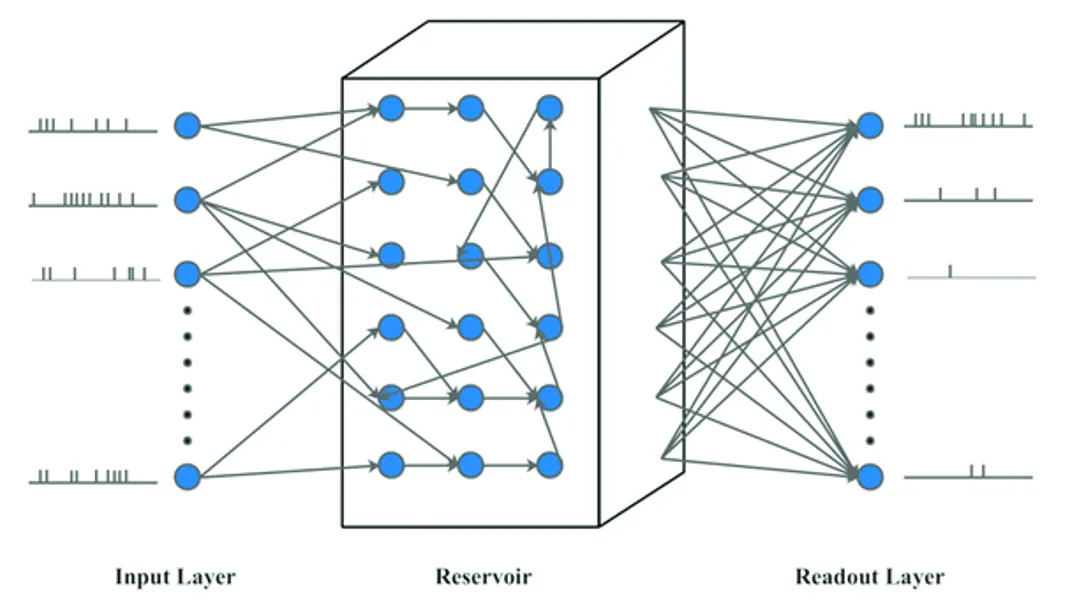

- The `input layer` receives the data typically encoded as a spike sequence, where each spike represents a discrete event or feature in the input data. e.g., in the context of time series prediction, each spike in the input sequence could correspond to a data point or a time step in the time series.

- The `reservoir layer` consists of a large number of recurrent units interconnected in a sparsely connected manner. Each unit in the reservoir computes a nonlinear transformation of its inputs and passes the result to other units through recurrent connections.

- The `readout layer` typically consists of one or more linear or nonlinear transformation layers followed by an output layer, which can be trained using supervised learning techniques to perform tasks.

LNNs don’t require vast amounts of labelled training data and are more `resilient towards noise and disturbance` in the input signal. 

LNNs use a process called **Backpropagation Through Time (BPTT)** to learn from data. This involves unrolling the network over a sequence of time states, allowing the model to learn from a series of events. As the network processes this sequence, it can adjust its connections, thanks to the liquid time constant.

## Challenges of LNNs

- `vanishing gradient problem`: 
    - gradients used to update the weights of the neural network become extremely small. 
    - prevents the network from reaching the optimum weights, and limits its ability to learn long-term dependencies effectively.

- `parameter tuning issue`: Finding suitable parameter settings for the best performance often requires an iterative process, which can be time-consuming and costly. The parameter tuning should be done efficiently or correctly.

## Implement

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

### Define LNN model

In [2]:
# the differential equation for the liquid state
class LiquidTimeStep(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LiquidTimeStep, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.W_in = nn.Linear(input_size, hidden_size)
        self.W_h = nn.Linear(hidden_size, hidden_size)
        self.tau = nn.Parameter(torch.ones(hidden_size)) # represents the timescale for updating the hidden state.
    
    def forward(self, x, h):
        """
        x: Input at the current time-step (a vector of size input_size).
        h: The hidden state from the previous time-step (a vector of size hidden_size).
        """
        dx = torch.tanh(self.W_in(x) + self.W_h(h))
        h_new = h + (dx - h) / self.tau # implements a dynamic update rule
        return h_new

In [3]:
class LiquidNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LiquidNeuralNetwork, self).__init__()
        self.hidden_size = hidden_size
        self.liquid_step = LiquidTimeStep(input_size, hidden_size) # processes each time step.
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        """
        x: a batch of sequences (e.g., time-series data) of shape (batch_size, seq_len, input_size).
        """
        batch_size, seq_len, _ = x.size()
        # Initialize Hidden State
        h = torch.zeros(batch_size, self.hidden_size, device=x.device)
        for t in range(seq_len):
            # update the hidden state h based on the input at each time step t and the previous hidden state.
            h = self.liquid_step(x[:, t, :], h)
        output = self.output_layer(h)
        return output

In [4]:
# Hyperparameters
input_size = 10  
hidden_size = 20  
output_size = 1  # Output size for regression

# Create the model
model = LiquidNeuralNetwork(input_size, hidden_size, output_size)

# Define Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

c:\Users\dangc\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Training

In [6]:
# Dummy data for demonstration
batch_size, seq_len = 4, 6
x_train = torch.randn(batch_size, seq_len, input_size)
y_train = torch.randn(batch_size, output_size)

In [7]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()

    # Forward pass
    outputs = model(x_train)
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'epoch [{epoch + 1}/{num_epochs}], loss: {loss.item():.4f}')

epoch [10/100], loss: 1.2499
epoch [20/100], loss: 0.7809
epoch [30/100], loss: 0.4329
epoch [40/100], loss: 0.1989
epoch [50/100], loss: 0.0713
epoch [60/100], loss: 0.0213
epoch [70/100], loss: 0.0063
epoch [80/100], loss: 0.0009
epoch [90/100], loss: 0.0000
epoch [100/100], loss: 0.0002


# Summary

- LNNs are especially suitable for computationally constrained and safety-critical applications such as robotics and autonomous vehicles, where data is continuously fed to machine learning models.

- LNNs excel at processing time-varying data and capturing temporal dependencies. The dynamic recurrent nature of LNNs allows them to model complex temporal patterns and sequences effectively.

- LNNs have a fixed, randomly generated reservoir layer, which simplifies the training process and reduces the risk of overfitting.

- LNNs can be implemented efficiently in hardware and are suitable for real-time applications and embedded systems. Their efficient training and execution make them well-suited for applications requiring low-latency processing.

# Inference

[Liquid Neuronal Networks](https://medium.com/@andrea.rosales08/liquid-neuronal-networks-using-pytorch-0d0bef41d504)